Imports

In [45]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import time

Hyper-Parameter

In [56]:
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 10
batch_size = 32
latent_size = 128
image_shape = (1, 28, 28)
image_size = 1
for x in image_shape:
    image_size *= x
    
hidden_size = 256

Datasets

In [57]:
# inplace = True로 설정하면 원본 데이터 세트의 값이 정규화되어 변환됨됨
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5), std=(0.5), inplace=True)
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=False,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=False,
    transform=transform
)

# (32, 1, 28, 28)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# for - break 문을 활용해서 출력 가능한 데이터 확인
# feature data _ label data로 구성
for x, y in test_loader:
    print(y.shape)
    break

torch.Size([32])


Model Architecture

In [58]:
class GAN(torch.nn.Module):     # Base class for all neural network modules
    def __init__(self):
        super(GAN, self).__init__()     # 부모 클래스인 torch.nn.Module의 초기화 매서드를 호출하여 부모 클래스를 상속 받음
        
        self.generator = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    # _forward 함수를 정의하는 이유 : keras에서 model.fit()과 같은 개념이라고 생각할 것.
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        return pred.view(-1)

In [59]:
torch.manual_seed(random_seed)

model = GAN()   # GAN 모델 객체 생성

criterion = nn.BCELoss()
optim_gener = torch.optim.Adam(model.generator.parameters(), lr = generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr = discriminator_learning_rate)

model

GAN(
  (generator): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Training

In [60]:
start_time = time.time()

discr_costs = []
gener_costs = []

for epoch in range(num_epochs):
    model = model.train()   # train 모드로 설정 - 모델 내 레이어들이 업데이트 될 수 있도록 활성화
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.view(-1, image_size)    # 첫번째 input layer의 size를 맞추기 위함
        
        valid_label = torch.ones(targets.size(0)).float()
            # targets의 0번째 원소와 동일한 size에 float형 1을 채우기
        fake_label = torch.zeros(targets.size(0)).float()
            # fake는 거짓 label이기 때문에 0으로 채우기 (geneerator를 통해 생성된 데이터는 모두 거짓이기 때문에 0으로 처리해야함!)
        
        ### Train Generator
        z = torch.zeros(targets.size(0), latent_size).uniform_(-1.0, 1.0)
            # 잠재벡터 z 생성 (uniform : -1.0 ~ 1.0 분포를 갖는 난수 생성)
        
        generated_features = model.generator_forward(z)
            # generator를 먼저 돌려서 discriminator가 판단할 수 있는 자료 만들기
        discr_pred = model.discriminator_forward(generated_features)
            # 생성한 G(z)를 discriminator가 정오 판단
        gener_loss = criterion(discr_pred, valid_label)
            # generator는 D(G(z))가 1에 가깝도록 만들어야함으로,
            # 목적함수는 G(z)에 대한 discriminator의 예측값과 이 값이 정답일 경우를 계산해야
        
        optim_gener.zero_grad()
            # generator의 매개변수에 대한 gradient를 0으로 초기화
            # 이는 각 batch 별로 gradient를 누적하는 것을 방지하는 것으로,
            # .backward()를 호출할 때마다 gradient가 누적을 통해 학습되는데, .zero_grad()를 하지 않으면 누적 값을 누적하는 셈이 됨
        gener_loss.backward()
            # 역전파 알고리즘의 실행을 통한 gradient 계산 후 누적
        optim_gener.step()
            # 매개변수 업데이트 (gradient에 따라 매개변수를 조정하여 손실을 최소화)
        
        ### Train Discriminator
        discr_pred_real = model.discriminator_forward(features)
        discr_loss_real = criterion(discr_pred_real, valid_label)
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
            # .detach() : gradient 추척을 비활성화하여 해당 tensor로부터 gradient 계산을 하지 않는 메서드
            # discriminator는 학습에 있어 fake 데이터는 graident 추적을 할 필요가 없으므로 .detach를 해야함
        discr_loss_fake = criterion(discr_pred_fake, fake_label)
        discr_loss = 0.5 * (discr_loss_real + discr_loss_fake)
            # discriminator의 목적 함수의 대상
            
        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()
        
        discr_costs.append(discr_loss.item())   # 텐서 데이터를 Python 숫자로 변환하여 해당 리스트에 append
        gener_costs.append(gener_loss.item())
        
        ### Logging : SW application의 실행 중에 발생하는 이벤트, 상태, 정보 등을 기록하는 프로세스
        if not batch_idx % 100:
            print("Epoch: %0.3d / %0.3d | Batch: %0.3d / %0.3d | Gen / Dis Loss: %0.4f / %0.4f"
                  %(epoch + 1, num_epochs, batch_idx,
                    len(train_loader), gener_loss, discr_loss))
    print("Time Elapsed: %.2f min" % ((time.time() - start_time) / 60))
print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))

Epoch: 001 / 010 | Batch: 000 / 1875 | Gen / Dis Loss: 0.7038 / 0.6901
Epoch: 001 / 010 | Batch: 100 / 1875 | Gen / Dis Loss: 2.2056 / 0.1033
Epoch: 001 / 010 | Batch: 200 / 1875 | Gen / Dis Loss: 8.8608 / 0.0008
Epoch: 001 / 010 | Batch: 300 / 1875 | Gen / Dis Loss: 4.6631 / 0.0093
Epoch: 001 / 010 | Batch: 400 / 1875 | Gen / Dis Loss: 6.0498 / 0.0650
Epoch: 001 / 010 | Batch: 500 / 1875 | Gen / Dis Loss: 4.2900 / 0.0653
Epoch: 001 / 010 | Batch: 600 / 1875 | Gen / Dis Loss: 4.2701 / 0.0124
Epoch: 001 / 010 | Batch: 700 / 1875 | Gen / Dis Loss: 17.5283 / 0.1113
Epoch: 001 / 010 | Batch: 800 / 1875 | Gen / Dis Loss: 11.3270 / 0.2330
Epoch: 001 / 010 | Batch: 900 / 1875 | Gen / Dis Loss: 4.8639 / 0.0795
Epoch: 001 / 010 | Batch: 1000 / 1875 | Gen / Dis Loss: 4.3857 / 0.0468
Epoch: 001 / 010 | Batch: 1100 / 1875 | Gen / Dis Loss: 4.2285 / 0.1207
Epoch: 001 / 010 | Batch: 1200 / 1875 | Gen / Dis Loss: 9.6523 / 0.0015
Epoch: 001 / 010 | Batch: 1300 / 1875 | Gen / Dis Loss: 6.2419 / 0.0044


Evaluation

In [61]:
import matplotlib.pyplot as plt

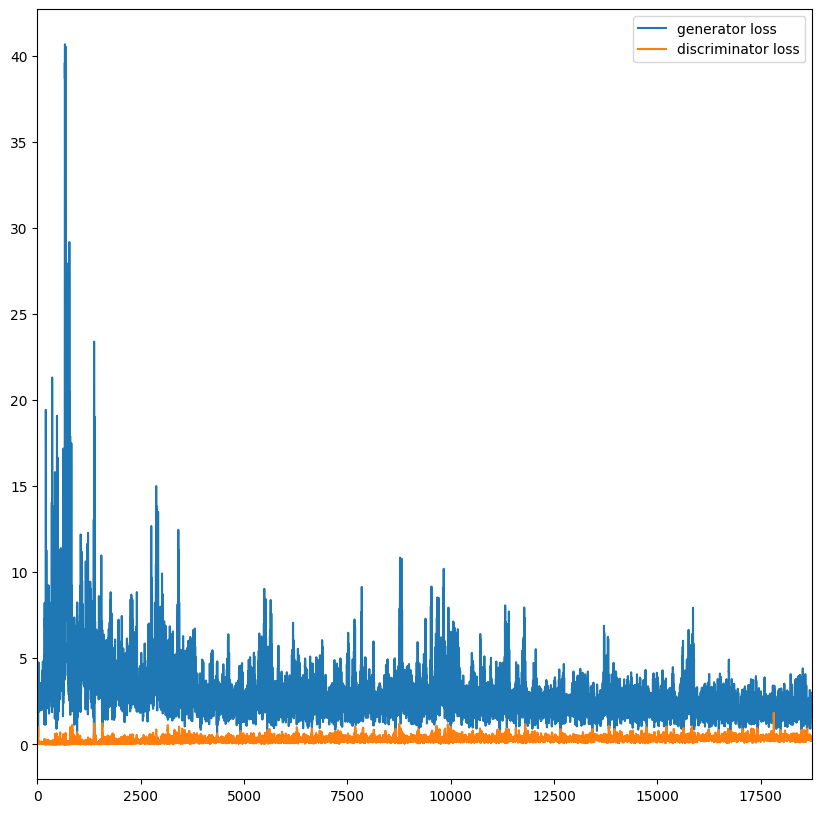

In [66]:
plt.figure(figsize = (10,10))
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.margins(x=0)
plt.show()

### GAN은 Generator와 Discriminator가 적대적인 관계이므로, 각 batch와 data_point 요소에서 loss 값이 교차하며 수렴하는 것이 가장 좋은 모양


Evaluation

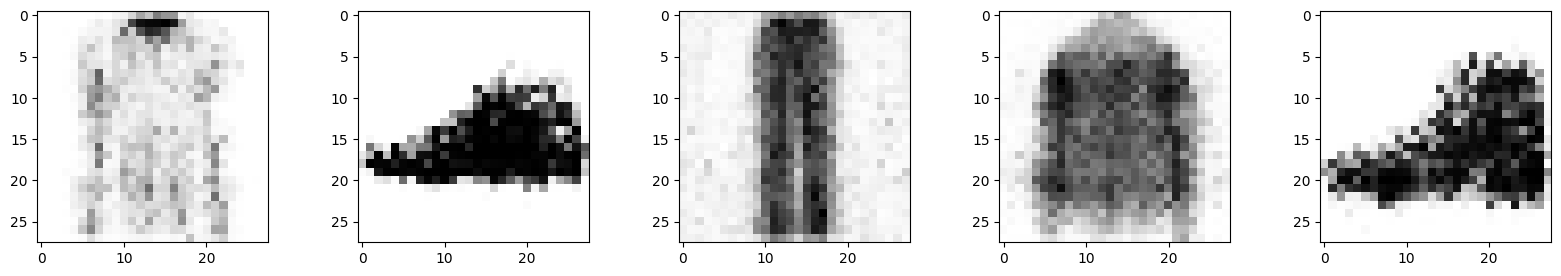

In [65]:
model.eval()    # evaluation 모드로 설정 - 모델 내 레이어들이 업데이트 되지 않도록 비활성화

z = torch.zeros((5, latent_size)).uniform_(-1.0, 1.0)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))

for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].detach(), cmap='binary')